In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [2]:
# Load data (data source: https://finance.yahoo.com/quote/MSFT/history/)
data = pd.read_csv(r"C:\Users\htet\Documents\backup\prediction_ms_stock_prices\MSFT.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060657,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,47894400
...,...,...,...,...,...,...,...
9356,2023-04-27,295.970001,305.200012,295.250000,304.829987,304.829987,46462600
9357,2023-04-28,304.010010,308.929993,303.309998,307.260010,307.260010,36446700
9358,2023-05-01,306.970001,308.600006,305.149994,305.559998,305.559998,21294100
9359,2023-05-02,307.760010,309.179993,303.910004,305.410004,305.410004,26404400


In [3]:
def drop_columns(dataframe, cols):
    dataframe = dataframe.drop(cols, axis=1)
    return dataframe

data = drop_columns(data, ["Open", "High", "Low", "Adj Close", "Volume"])
data.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


In [4]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

data['Date'] = data['Date'].apply(str_to_datetime)
data['Date'].head()

0   1986-03-13
1   1986-03-14
2   1986-03-17
3   1986-03-18
4   1986-03-19
Name: Date, dtype: datetime64[ns]

In [5]:
data = data.set_index("Date")
data.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


In [6]:
data['Close'].describe()

count    9361.000000
mean       47.864888
std        69.759779
min         0.090278
25%         5.304688
50%        27.080000
75%        43.360001
max       343.109985
Name: Close, dtype: float64

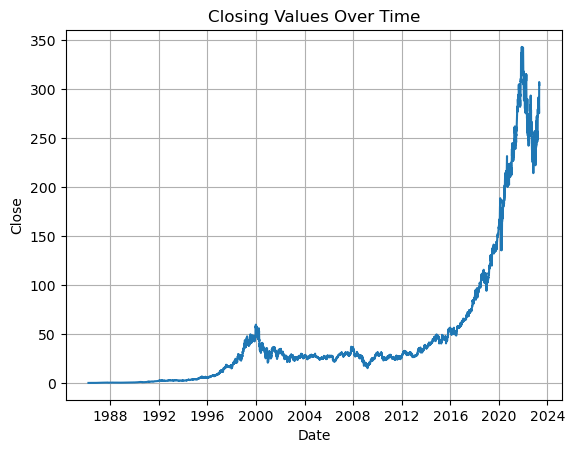

In [7]:
# Plot yearly closing values over time
plt.plot(data.index, data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Closing Values Over Time")
plt.grid()

count     38.000000
mean      51.474578
std       75.109397
min        0.117596
25%        5.778952
50%       26.852981
75%       43.438429
max      275.940754
Name: Close, dtype: float64


Text(0.5, 1.0, 'Yearly Closing Value Over Time')

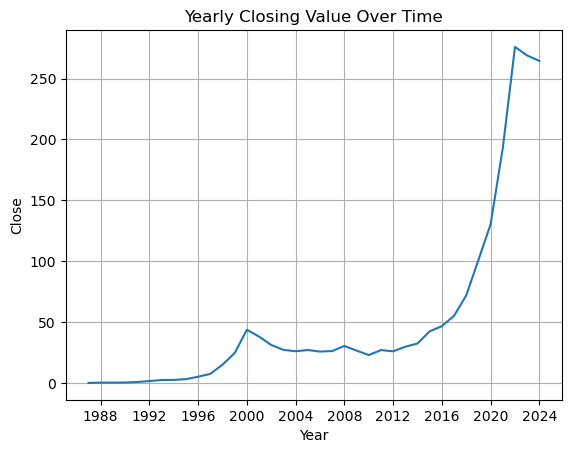

In [8]:
# Yearly data distribution
data_year = data.Close.resample('Y').mean()
print(data_year.describe())

# Plot quaterly closing value over time
plt.plot(data_year.index, data_year)
plt.xlabel("Year")
plt.ylabel("Close")
plt.grid()
plt.title("Yearly Closing Value Over Time")

count    150.000000
mean      48.710331
std       71.435336
min        0.096282
25%        5.267330
50%       27.024108
75%       44.339050
max      324.210157
Name: Close, dtype: float64


Text(0.5, 1.0, 'Quarterly Closing Value Over Time')

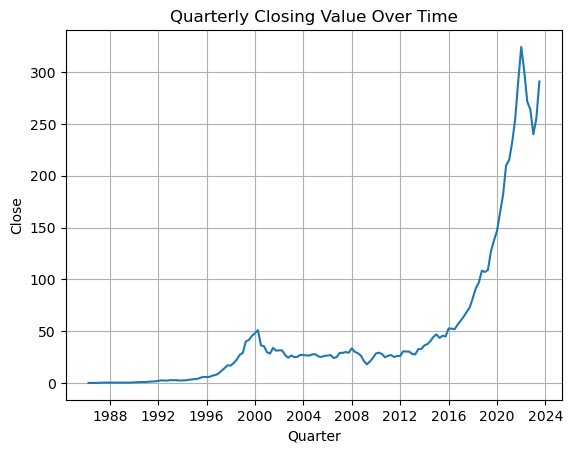

In [9]:
# Quarterly data distribution
data_quarter = data.Close.resample('Q').mean()
print(data_quarter.describe())

# Plot closing value over time
plt.plot(data_quarter.index, data_quarter)
plt.xlabel("Quarter")
plt.ylabel("Close")
plt.grid()
plt.title("Quarterly Closing Value Over Time")

count    447.000000
mean      48.411090
std       70.663067
min        0.096282
25%        5.456676
50%       27.075263
75%       43.514048
max      335.870950
Name: Close, dtype: float64


Text(0.5, 1.0, 'Monthly Closing Value Over Time')

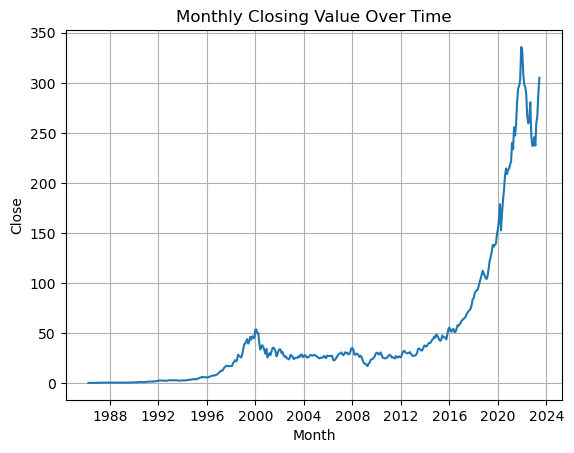

In [10]:
# Monthly data distribution
data_month = data.Close.resample('M').mean()
print(data_month.describe())

# Plot Monthly closing value over time
plt.plot(data_month.index, data_month)
plt.xlabel("Month")
plt.ylabel("Close")
plt.grid()
plt.title("Monthly Closing Value Over Time")

In [11]:
# Create windows based on lags
def create_window(df, lag):
    if lag < len(df):
        l = lag

        while True:
            df[f"Target_Close_{l}"] = df.Close.shift(l)

            l = l-1
            if l<1:
                break
        
        df["Target"] = df.Close.copy()
        return df
    
    else:
        raise ValueError(f"Lag value ({lag}) should be less than the size of data ({len(df)}).")

try:
    lag = 2
    target_data = data.copy()
    target_data = create_window(target_data, lag)
     
except ValueError as e:
    print(str(e))
    
target_data

,Close,Target_Close_2,Target_Close_1,Target
Date,,,,
1986-03-13,0.097222,NaN,NaN,0.097222
1986-03-14,0.100694,NaN,0.097222,0.100694
1986-03-17,0.102431,0.097222,0.100694,0.102431
1986-03-18,0.099826,0.100694,0.102431,0.099826
1986-03-19,0.098090,0.102431,0.099826,0.098090
...,...,...,...,...
2023-04-27,304.829987,275.420013,295.369995,304.829987
2023-04-28,307.260010,295.369995,304.829987,307.260010
2023-05-01,305.559998,304.829987,307.260010,305.559998


In [12]:
# Delete redundant columns
deleted_cols = ["Close"]
target_data = drop_columns(target_data, deleted_cols)
target_data

,Target_Close_2,Target_Close_1,Target
Date,,,
1986-03-13,NaN,NaN,0.097222
1986-03-14,NaN,0.097222,0.100694
1986-03-17,0.097222,0.100694,0.102431
1986-03-18,0.100694,0.102431,0.099826
1986-03-19,0.102431,0.099826,0.098090
...,...,...,...
2023-04-27,275.420013,295.369995,304.829987
2023-04-28,295.369995,304.829987,307.260010
2023-05-01,304.829987,307.260010,305.559998


In [13]:
# Choose data period
def selected_targets(dataframe, first_date, last_date):
    if first_date > dataframe.index[lag-1]:
        target_selected = dataframe.loc[first_date:last_date]
        return target_selected
    else:
        raise ValueError(f"First date should be greater than {first_date}.")     

try:  
    first_date = '1986-03-20'
    last_date = '2023-05-03'
    target_selected = selected_targets(target_data, str_to_datetime(first_date), str_to_datetime(last_date))
    print("Selected target shape: ", target_selected.shape)
    
except ValueError as e:
    print(str(e))

Selected target shape:  (9356, 3)


In [14]:
# Prepare data
def prepare_data(df):
    # convert df to numpy array
    dates = df.index.to_numpy()
    X = df.to_numpy()[:, :-1]
    y = df.to_numpy()[:, -1]
    return dates, X, y
    
dates, X, y = prepare_data(target_selected)
dates.shape, X.shape, y.shape

((9356,), (9356, 2), (9356,))

In [15]:
# Split train and test data
train_size = int(len(dates)*0.8)
dates_train = dates[:train_size]
X_train = X[:train_size]
y_train = y[:train_size]
dates_test = dates[train_size:]
X_test = X[train_size:]
y_test = y[train_size:]

X_train.shape, X_test.shape

((7484, 2), (1872, 2))

In [16]:
# Split train and validation data
train_nn_size = int(len(dates_train)*0.8)
dates_train_nn = dates_train[:train_nn_size]
X_train_nn = X_train[:train_nn_size]
y_train_nn = y_train[:train_nn_size]
dates_val_nn = dates_train[train_nn_size:]
X_val_nn = X_train[train_nn_size:]
y_val_nn = y_train[train_nn_size:]

X_train_nn.shape, X_val_nn.shape

((5987, 2), (1497, 2))

In [17]:
# Standardize X data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train_nn = scaler.transform(X_train_nn)
X_val_nn = scaler.transform(X_val_nn)

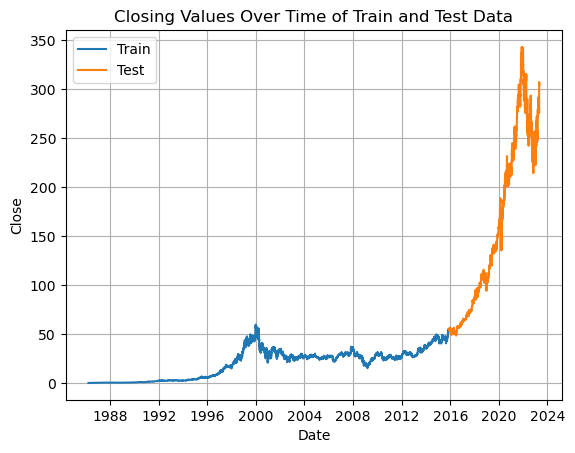

In [18]:
# Plot train and test data
plt.plot(dates_train, y_train)
plt.plot(dates_test, y_test)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Closing Values Over Time of Train and Test Data")
plt.grid()
plt.legend(["Train", "Test"])

In [19]:
# Train and test target data distribution
pd.DataFrame(y_train).describe(), pd.DataFrame(y_test).describe()

(                 0
 count  7484.000000
 mean     19.820053
 std      14.861314
 min       0.090278
 25%       2.667643
 50%      25.085000
 75%      29.350000
 max      59.562500,
                  0
 count  1872.000000
 mean    160.111880
 std      87.769884
 min      48.430000
 25%      75.407501
 50%     137.099998
 75%     242.497501
 max     343.109985)

In [20]:
# Create linear regression model
model_lr = LinearRegression(fit_intercept='True')
model_sv = SVR(kernel='linear', C=0.1, epsilon=0.1)
model_rf = RandomForestRegressor(n_estimators=50, max_depth=None)
model_gb = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3)
model_kn = KNeighborsRegressor(n_neighbors=3, weights='uniform')

# Set the time series cross-validation scheme
tscv = TimeSeriesSplit(n_splits=6)
mae_scores_lr = 0.0
mae_scores_sv = 0.0
mae_scores_rf = 0.0
mae_scores_gb = 0.0
mae_scores_kn = 0.0

for train_index, val_index in tscv.split(X_train):
    X_train_cv, X_val = X_train[train_index], X_train[val_index]
    y_train_cv, y_val = y_train[train_index], y_train[val_index]
    
    # Train models
    model_lr.fit(X_train, y_train)
    model_sv.fit(X_train, y_train)
    model_rf.fit(X_train, y_train)
    model_gb.fit(X_train, y_train)
    model_kn.fit(X_train, y_train)

    # Evaluate performance on the validation set
    y_pred_val_lr = model_lr.predict(X_val)
    y_pred_val_sv = model_sv.predict(X_val)
    y_pred_val_rf = model_rf.predict(X_val)
    y_pred_val_gb = model_gb.predict(X_val)
    y_pred_val_kn = model_kn.predict(X_val)
    mae_scores_lr += mean_absolute_error(y_val, y_pred_val_lr)
    mae_scores_sv += mean_absolute_error(y_val, y_pred_val_sv)
    mae_scores_rf += mean_absolute_error(y_val, y_pred_val_rf)
    mae_scores_gb += mean_absolute_error(y_val, y_pred_val_gb)
    mae_scores_kn += mean_absolute_error(y_val, y_pred_val_kn)

print("***Validation Scores***")
print('Validation MAE (Linear Regression): ', mae_scores_lr)
print('Validation MAE (Support Vector Regressor): ', mae_scores_sv)
print('Validation MAE (Random Forest Regressor): ', mae_scores_rf)
print('Validation MAE (Gradient Boosting Regressor): ', mae_scores_gb)
print('Validation MAE (KNeighbors regressor): ', mae_scores_kn)

***Validation Scores***
Validation MAE (Linear Regression):  1.9437064471996488
Validation MAE (Support Vector Regressor):  2.051131653975269
Validation MAE (Random Forest Regressor):  0.8500776592101653
Validation MAE (Gradient Boosting Regressor):  1.9971665481808736
Validation MAE (KNeighbors regressor):  1.6820812157779854


In [21]:
# Define the hyperparameters for neural networks
best_hps = {'num_layers': 49, 'units_0': 576, 'units_1': 224, 'learning_rate': 1e-05, 'units_2': 288, 'units_3': 64, 
            'units_4': 992, 'units_5': 128, 'units_6': 64, 'units_7': 448, 'units_8': 128, 'units_9': 448, 'units_10': 288, 
            'units_11': 576, 'units_12': 672, 'units_13': 800, 'units_14': 864, 'units_15': 896, 'units_16': 800, 
            'units_17': 960, 'units_18': 96, 'units_19': 32, 'units_20': 960, 'units_21': 768, 'units_22': 416, 
            'units_23': 512, 'units_24': 640, 'units_25': 928, 'units_26': 320, 'units_27': 32, 'units_28': 480, 
            'units_29': 288, 'units_30': 960, 'units_31': 64, 'units_32': 896, 'units_33': 320, 'units_34': 832, 
            'units_35': 352, 'units_36': 512, 'units_37': 96, 'units_38': 416, 'units_39': 1024, 'units_40': 736, 
            'units_41': 672, 'units_42': 608, 'units_43': 736, 'units_44': 608, 'units_45': 32, 'units_46': 32, 
            'units_47': 32, 'units_48': 32}

# Build the model
model_nn = Sequential()
for i in range(best_hps['num_layers']):
    units = best_hps[f'units_{i}']
    if i == 0:
        model_nn.add(Dense(units=units, activation='relu', input_shape=(lag,)))
    else:
        model_nn.add(Dense(units=units, activation='relu'))
model_nn.add(Dense(units=1, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=best_hps['learning_rate'])
model_nn.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

# Train the model using the full training set
history = model_nn.fit(X_train_nn, y_train_nn, epochs=100, validation_data=(X_val_nn, y_val_nn))

Epoch 1/100
188/188 [==============================] - 38s 166ms/step - loss: 16.0574 - mean_absolute_error: 16.0574 - val_loss: 23.6980 - val_mean_absolute_error: 23.6980
Epoch 2/100
188/188 [==============================] - 31s 165ms/step - loss: 4.8097 - mean_absolute_error: 4.8097 - val_loss: 1.1587 - val_mean_absolute_error: 1.1587
Epoch 3/100
188/188 [==============================] - 30s 159ms/step - loss: 0.5322 - mean_absolute_error: 0.5322 - val_loss: 0.3766 - val_mean_absolute_error: 0.3766
Epoch 4/100
188/188 [==============================] - 30s 158ms/step - loss: 0.3442 - mean_absolute_error: 0.3442 - val_loss: 0.5579 - val_mean_absolute_error: 0.5579
Epoch 5/100
188/188 [==============================] - 31s 165ms/step - loss: 0.3257 - mean_absolute_error: 0.3257 - val_loss: 0.4705 - val_mean_absolute_error: 0.4705
Epoch 6/100
188/188 [==============================] - 30s 161ms/step - loss: 0.3297 - mean_absolute_error: 0.3297 - val_loss: 0.4988 - val_mean_absolute_er

188/188 [==============================] - 31s 164ms/step - loss: 0.3052 - mean_absolute_error: 0.3052 - val_loss: 0.5428 - val_mean_absolute_error: 0.5428
Epoch 50/100
188/188 [==============================] - 30s 157ms/step - loss: 0.3093 - mean_absolute_error: 0.3093 - val_loss: 0.4144 - val_mean_absolute_error: 0.4144
Epoch 51/100
188/188 [==============================] - 29s 156ms/step - loss: 0.3270 - mean_absolute_error: 0.3270 - val_loss: 0.3659 - val_mean_absolute_error: 0.3659
Epoch 52/100
188/188 [==============================] - 29s 157ms/step - loss: 0.3068 - mean_absolute_error: 0.3068 - val_loss: 0.3537 - val_mean_absolute_error: 0.3537
Epoch 53/100
188/188 [==============================] - 29s 155ms/step - loss: 0.3254 - mean_absolute_error: 0.3254 - val_loss: 0.4391 - val_mean_absolute_error: 0.4391
Epoch 54/100
188/188 [==============================] - 30s 158ms/step - loss: 0.3346 - mean_absolute_error: 0.3346 - val_loss: 0.8212 - val_mean_absolute_error: 0.8212

188/188 [==============================] - 28s 150ms/step - loss: 0.3344 - mean_absolute_error: 0.3344 - val_loss: 0.3544 - val_mean_absolute_error: 0.3544
Epoch 98/100
188/188 [==============================] - 35s 185ms/step - loss: 0.3220 - mean_absolute_error: 0.3220 - val_loss: 0.4098 - val_mean_absolute_error: 0.4098
Epoch 99/100
188/188 [==============================] - 30s 159ms/step - loss: 0.3025 - mean_absolute_error: 0.3025 - val_loss: 0.5362 - val_mean_absolute_error: 0.5362
Epoch 100/100
188/188 [==============================] - 31s 164ms/step - loss: 0.3124 - mean_absolute_error: 0.3124 - val_loss: 0.6257 - val_mean_absolute_error: 0.6257


In [23]:
# Save the models
path = r'C:\Users\htet\Documents\backup\prediction_ms_stock_prices'

with open(path + r"\model_lr_lag2.pkl", 'wb') as f:
    pickle.dump(model_lr, f)
    
with open(path + r"\model_sv_lag2.pkl", 'wb') as f:
    pickle.dump(model_sv, f)

with open(path + r"\model_rf_lag2.pkl", 'wb') as f:
    pickle.dump(model_rf, f)
    
with open(path + r"\model_gb_lag2.pkl", 'wb') as f:
    pickle.dump(model_gb, f)
    
with open(path + r"\model_kn_lag2.pkl", 'wb') as f:
    pickle.dump(model_kn, f)
    
with open(path + r"\model_nn_lag2.pkl", 'wb') as f:
    pickle.dump(model_nn, f)

In [24]:
# Make predictions
y_pred_test_lr = model_lr.predict(X_test)
y_pred_test_sv = model_sv.predict(X_test)
y_pred_test_rf = model_rf.predict(X_test)
y_pred_test_gb = model_gb.predict(X_test)
y_pred_test_kn = model_kn.predict(X_test)
y_pred_test_nn = model_nn.predict(X_test)

# Evaluate model performance
mae_lr = mean_absolute_error(y_test, y_pred_test_lr)
mae_sv = mean_absolute_error(y_test, y_pred_test_sv)
mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
mae_gb = mean_absolute_error(y_test, y_pred_test_gb)
mae_kn = mean_absolute_error(y_test, y_pred_test_kn)
mae_nn = mean_absolute_error(y_test, y_pred_test_nn)

mse_lr = mean_squared_error(y_test, y_pred_test_lr)
mse_sv = mean_squared_error(y_test, y_pred_test_sv)
mse_rf = mean_squared_error(y_test, y_pred_test_rf)
mse_gb = mean_squared_error(y_test, y_pred_test_gb)
mse_kn = mean_squared_error(y_test, y_pred_test_kn)
mse_nn = mean_squared_error(y_test, y_pred_test_nn)

rmse_lr = mse_lr ** 0.5
rmse_sv = mse_sv ** 0.5
rmse_rf = mse_rf ** 0.5
rmse_gb = mse_gb ** 0.5
rmse_kn = mse_kn ** 0.5
rmse_nn = mse_nn ** 0.5

print("\n*****Testing score******")
print("\n***Linear Regression***")
print('MAE: %.2f' % mae_lr)
print('MSE: %.2f' % mse_lr)
print('RMSE: %.2f' % rmse_lr)
print("\n***Support Vector Regressor***")
print('MAE: %.2f' % mae_sv)
print('MSE: %.2f' % mse_sv)
print('RMSE: %.2f' % rmse_sv)
print("\n***Random Forest Regressor***")
print('MAE: %.2f' % mae_rf)
print('MSE: %.2f' % mse_rf)
print('RMSE: %.2f' % rmse_rf)
print("\n***Gradient Boosting Regressor***")
print('MAE: %.2f' % mae_gb)
print('MSE: %.2f' % mse_gb)
print('RMSE: %.2f' % rmse_gb)
print("\n***KNeighbors regressor***")
print('MAE: %.2f' % mae_kn)
print('MSE: %.2f' % mse_kn)
print('RMSE: %.2f' % rmse_kn)
print("\n***Neural Networks***")
print('MAE: %.2f' % mae_nn)
print('MSE: %.2f' % mse_nn)
print('RMSE: %.2f' % rmse_nn)

59/59 [==============================] - 2s 20ms/step

*****Testing score******

***Linear Regression***
MAE: 2.10
MSE: 11.64
RMSE: 3.41

***Support Vector Regressor***
MAE: 2.21
MSE: 12.34
RMSE: 3.51

***Random Forest Regressor***
MAE: 102.07
MSE: 17975.18
RMSE: 134.07

***Gradient Boosting Regressor***
MAE: 102.84
MSE: 18155.04
RMSE: 134.74

***KNeighbors regressor***
MAE: 102.12
MSE: 17980.90
RMSE: 134.09

***Neural Networks***
MAE: 2.52
MSE: 14.29
RMSE: 3.78


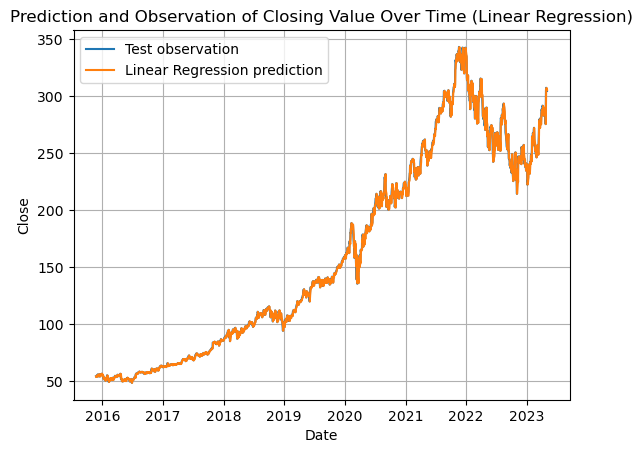

In [25]:
# Plot the model performance
plt.plot(dates_test, y_test)
plt.plot(dates_test, y_pred_test_lr)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Prediction and Observation of Closing Value Over Time (Linear Regression)")
plt.grid()
plt.legend(["Test observation", 
            "Linear Regression prediction"])

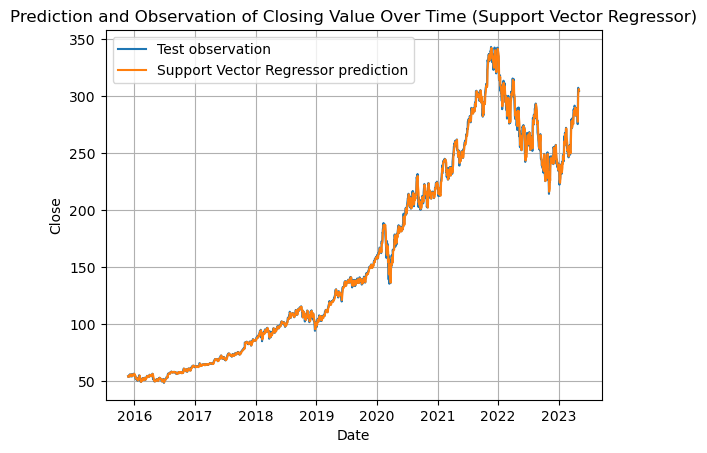

In [26]:
# Plot the model performance
plt.plot(dates_test, y_test)
plt.plot(dates_test, y_pred_test_sv)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Prediction and Observation of Closing Value Over Time (Support Vector Regressor)")
plt.grid()
plt.legend(["Test observation", 
            "Support Vector Regressor prediction"])

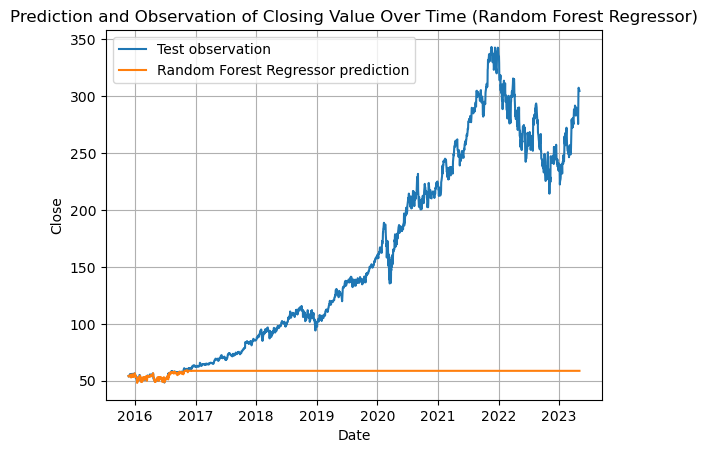

In [27]:
# Plot the model performance
plt.plot(dates_test, y_test)
plt.plot(dates_test, y_pred_test_rf)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Prediction and Observation of Closing Value Over Time (Random Forest Regressor)")
plt.grid()
plt.legend(["Test observation", 
            "Random Forest Regressor prediction"])

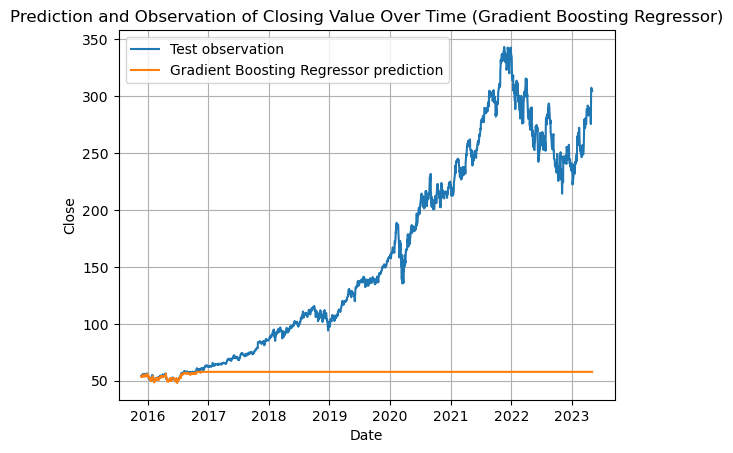

In [28]:
# Plot the model performance
plt.plot(dates_test, y_test)
plt.plot(dates_test, y_pred_test_gb)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Prediction and Observation of Closing Value Over Time (Gradient Boosting Regressor)")
plt.grid()
plt.legend(["Test observation", 
            "Gradient Boosting Regressor prediction"])

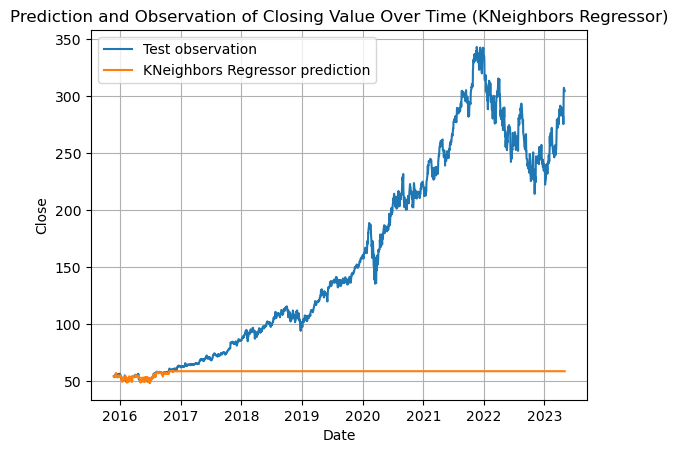

In [29]:
# Plot the model performance
plt.plot(dates_test, y_test)
plt.plot(dates_test, y_pred_test_kn)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Prediction and Observation of Closing Value Over Time (KNeighbors Regressor)")
plt.grid()
plt.legend(["Test observation", 
            "KNeighbors Regressor prediction"])

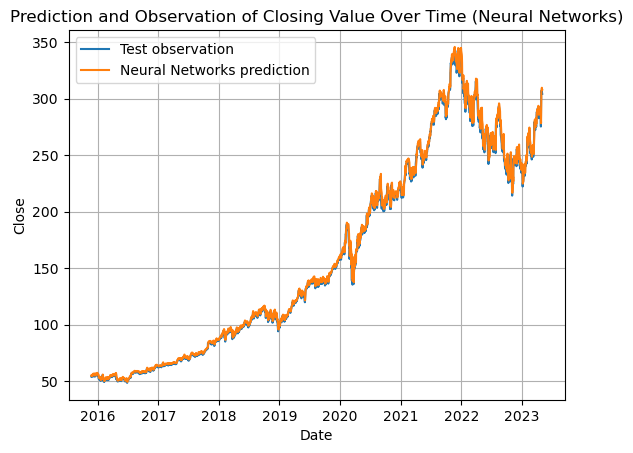

In [30]:
# Plot the model performance
plt.plot(dates_test, y_test)
plt.plot(dates_test, y_pred_test_nn)
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Prediction and Observation of Closing Value Over Time (Neural Networks)")
plt.grid()
plt.legend(["Test observation", 
            "Neural Networks prediction"])

In [31]:
# Predict new data
new_data = np.array(['2023-05-09', 310.65, 308.65, 307.00])
date_new = new_data[0]
X_new = new_data[1:-1]
X_new = X_new.reshape((-1, len(X_new)))
X_new = scaler.transform(X_new)
y_new = new_data[-1]

# Load the best model
with open(path + r"\model_lr_lag2.pkl", 'rb') as f:
    best_model_lr = pickle.load(f)
    
prediction = best_model_lr.predict(X_new)
print(f"Observation: {date_new} {float(y_new):.2f}")
print(f"Prediction: {date_new} {prediction[0]:.2f}")

Observation: 2023-05-09 307.00
Prediction: 2023-05-09 308.59
